In [49]:
#import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [50]:
# antibiotic data
file_path_antibiotics = '/Users/renata.m/Desktop/Thesis/Rashidi_Data_2022/AntibioticsTable.csv'
antibiotics_data = pd.read_csv(file_path_antibiotics)

In [51]:
#sra data with time 
file_path_metadata = '/Users/renata.m/QIIME2/qiime2-final_analysis-silva_abx/sra_metadata_time.tsv'
sra_metadata = pd.read_csv(file_path_metadata, sep='\t')
sra_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 494 non-null    object 
 1   Patient_ID                         494 non-null    object 
 2   SampleDayRelativeToD1Chemo         494 non-null    int64  
 3   Age                                494 non-null    int64  
 4   Sex                                494 non-null    object 
 5   Disease_Phase                      494 non-null    object 
 6   Chemotherapy                       494 non-null    object 
 7   FirstNFDayRelativeToD1Chemo        473 non-null    float64
 8   DiarrheaStartDayRelativeToD1Chemo  289 non-null    float64
 9   DiarrheaEndDayRelativeToD1Chemo    289 non-null    float64
 10  FirstCDiffDayRelativeToD1Chemo     176 non-null    float64
 11  CDiff_infection                    494 non-null    int64  

In [52]:
#data preprocessing
antibiotic_df = antibiotics_data.drop([0, 1]).reset_index(drop=True)
antibiotic_df.columns = ['Patient_ID', 'AntibacterialABx', 'StartDayRelativeToD1Chemo', 'StopDayRelativeToD1Chemo', 'Route']

antibiotics_data_cleaned = antibiotic_df.dropna(subset=['Patient_ID'])

antibiotics_data_cleaned = antibiotics_data_cleaned.drop(0).reset_index(drop=True)

#numeric
antibiotics_data_cleaned['StartDayRelativeToD1Chemo'] = pd.to_numeric(antibiotics_data_cleaned['StartDayRelativeToD1Chemo'])
antibiotics_data_cleaned['StopDayRelativeToD1Chemo'] = pd.to_numeric(antibiotics_data_cleaned['StopDayRelativeToD1Chemo'])

# filter study period
antibiotics_data_cleaned = antibiotics_data_cleaned[
    (antibiotics_data_cleaned['StartDayRelativeToD1Chemo'] >= -5) &
    (antibiotics_data_cleaned['StopDayRelativeToD1Chemo'] <= 30)
]

antibiotics_data_cleaned.head()

,Patient_ID,AntibacterialABx,StartDayRelativeToD1Chemo,StopDayRelativeToD1Chemo,Route
0,7D001,Cefepime,-1.0,14.0,IV
1,7D001,Piperacillin-Tazobactam,14.0,21.0,IV
2,7D001,Vancomycin,9.0,22.0,PO
6,7D002,Cefepime,-1.0,5.0,IV
7,7D002,Cefepime,9.0,26.0,IV


In [53]:
#data
metadata = sra_metadata
abx_history = antibiotics_data_cleaned

#abx of interest
abx_classes = ['Vancomycin', 'Levofloxacin', 'Metronidazole', 'Piperacillin-Tazobactam', 
               'Meropenem', 'Azithromycin', 'Cefepime']

summary_data = []

# Decay factor
decay_factor = 2

# Calculate decaye average
def calculate_decay(series, decay_factor):
    return sum(val * decay_factor**-i for i, val in enumerate(series))

# Loop through samples
for _, sample in metadata.iterrows():
    patient_id = sample['Patient_ID']
    sample_day = int(sample['SampleDayRelativeToD1Chemo']) 
    
    # Filter antibiotic exposure 
    patient_abx = abx_history[abx_history['Patient_ID'] == patient_id]
    

    sample_summary = {'Patient_ID': patient_id, 'ID': sample['ID']}
    
    # Loop antibioitics
    for abx_class in abx_classes:
        # Create the time series for the antibiotic class
        time_series = [0] * (sample_day + 1)
        
        abx_records = patient_abx[patient_abx['AntibacterialABx'] == abx_class]
        for _, abx in abx_records.iterrows():
            start = max(0, int(abx['StartDayRelativeToD1Chemo']))  
            stop = min(sample_day, int(abx['StopDayRelativeToD1Chemo'])) 
            for day in range(start, stop + 1):
                time_series[day] = 1
        
        # Calculate decay average
        decayed_average = calculate_decay(time_series, decay_factor)
        
        sample_summary[abx_class] = decayed_average
    
    summary_data.append(sample_summary)

# Create df
summary_df = pd.DataFrame(summary_data)

summary_df.head()

,Patient_ID,ID,Vancomycin,Levofloxacin,Metronidazole,Piperacillin-Tazobactam,Meropenem,Azithromycin,Cefepime
0,7D001,SRR7048546,0.000000,0.0,0.0,0.0,0.0,0.0,1.937500
1,7D001,SRR7048547,0.000000,0.0,0.0,0.0,0.0,0.0,1.968750
2,7D001,SRR7048548,0.000000,0.0,0.0,0.0,0.0,0.0,1.992188
3,7D001,SRR7048537,0.001953,0.0,0.0,0.0,0.0,0.0,1.998047
4,7D001,SRR7048536,0.003662,0.0,0.0,0.0,0.0,0.0,1.999756


In [54]:
shannon_df = pd.read_csv('/Users/renata.m/QIIME2/qiime2-final_analysis-silva/diversity_metrics/exported-shannon-vector/alpha-diversity.tsv', sep='\t')
shannon_df = shannon_df.rename({'Unnamed: 0':'ID'}, axis=1)
shannon_df.head()

,ID,shannon_entropy
0,SRR11423880,7.603781
1,SRR11423882,7.792365
2,SRR11423883,7.191944
3,SRR11423885,6.169068
4,SRR11423886,7.966423


In [55]:
abx_decay = summary_df[['ID', 'Vancomycin', 'Levofloxacin', 'Metronidazole', 'Meropenem', 'Piperacillin-Tazobactam', 'Azithromycin', 'Cefepime']]
shannon_abx_deday = shannon_df.merge(abx_decay, on='ID', how='inner')
shannon_abx_deday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       399 non-null    object 
 1   shannon_entropy          399 non-null    float64
 2   Vancomycin               399 non-null    float64
 3   Levofloxacin             399 non-null    float64
 4   Metronidazole            399 non-null    float64
 5   Meropenem                399 non-null    float64
 6   Piperacillin-Tazobactam  399 non-null    float64
 7   Azithromycin             399 non-null    float64
 8   Cefepime                 399 non-null    float64
dtypes: float64(8), object(1)
memory usage: 28.2+ KB


/var/folders/6q/6nzfxmt176v8n102ymkb7yw80000gn/T/ipykernel_38047/383063884.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=first_row_corr.index, y=first_row_corr.values, palette=palette)
/var/folders/6q/6nzfxmt176v8n102ymkb7yw80000gn/T/ipykernel_38047/383063884.py:12: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.barplot(x=first_row_corr.index, y=first_row_corr.values, palette=palette)


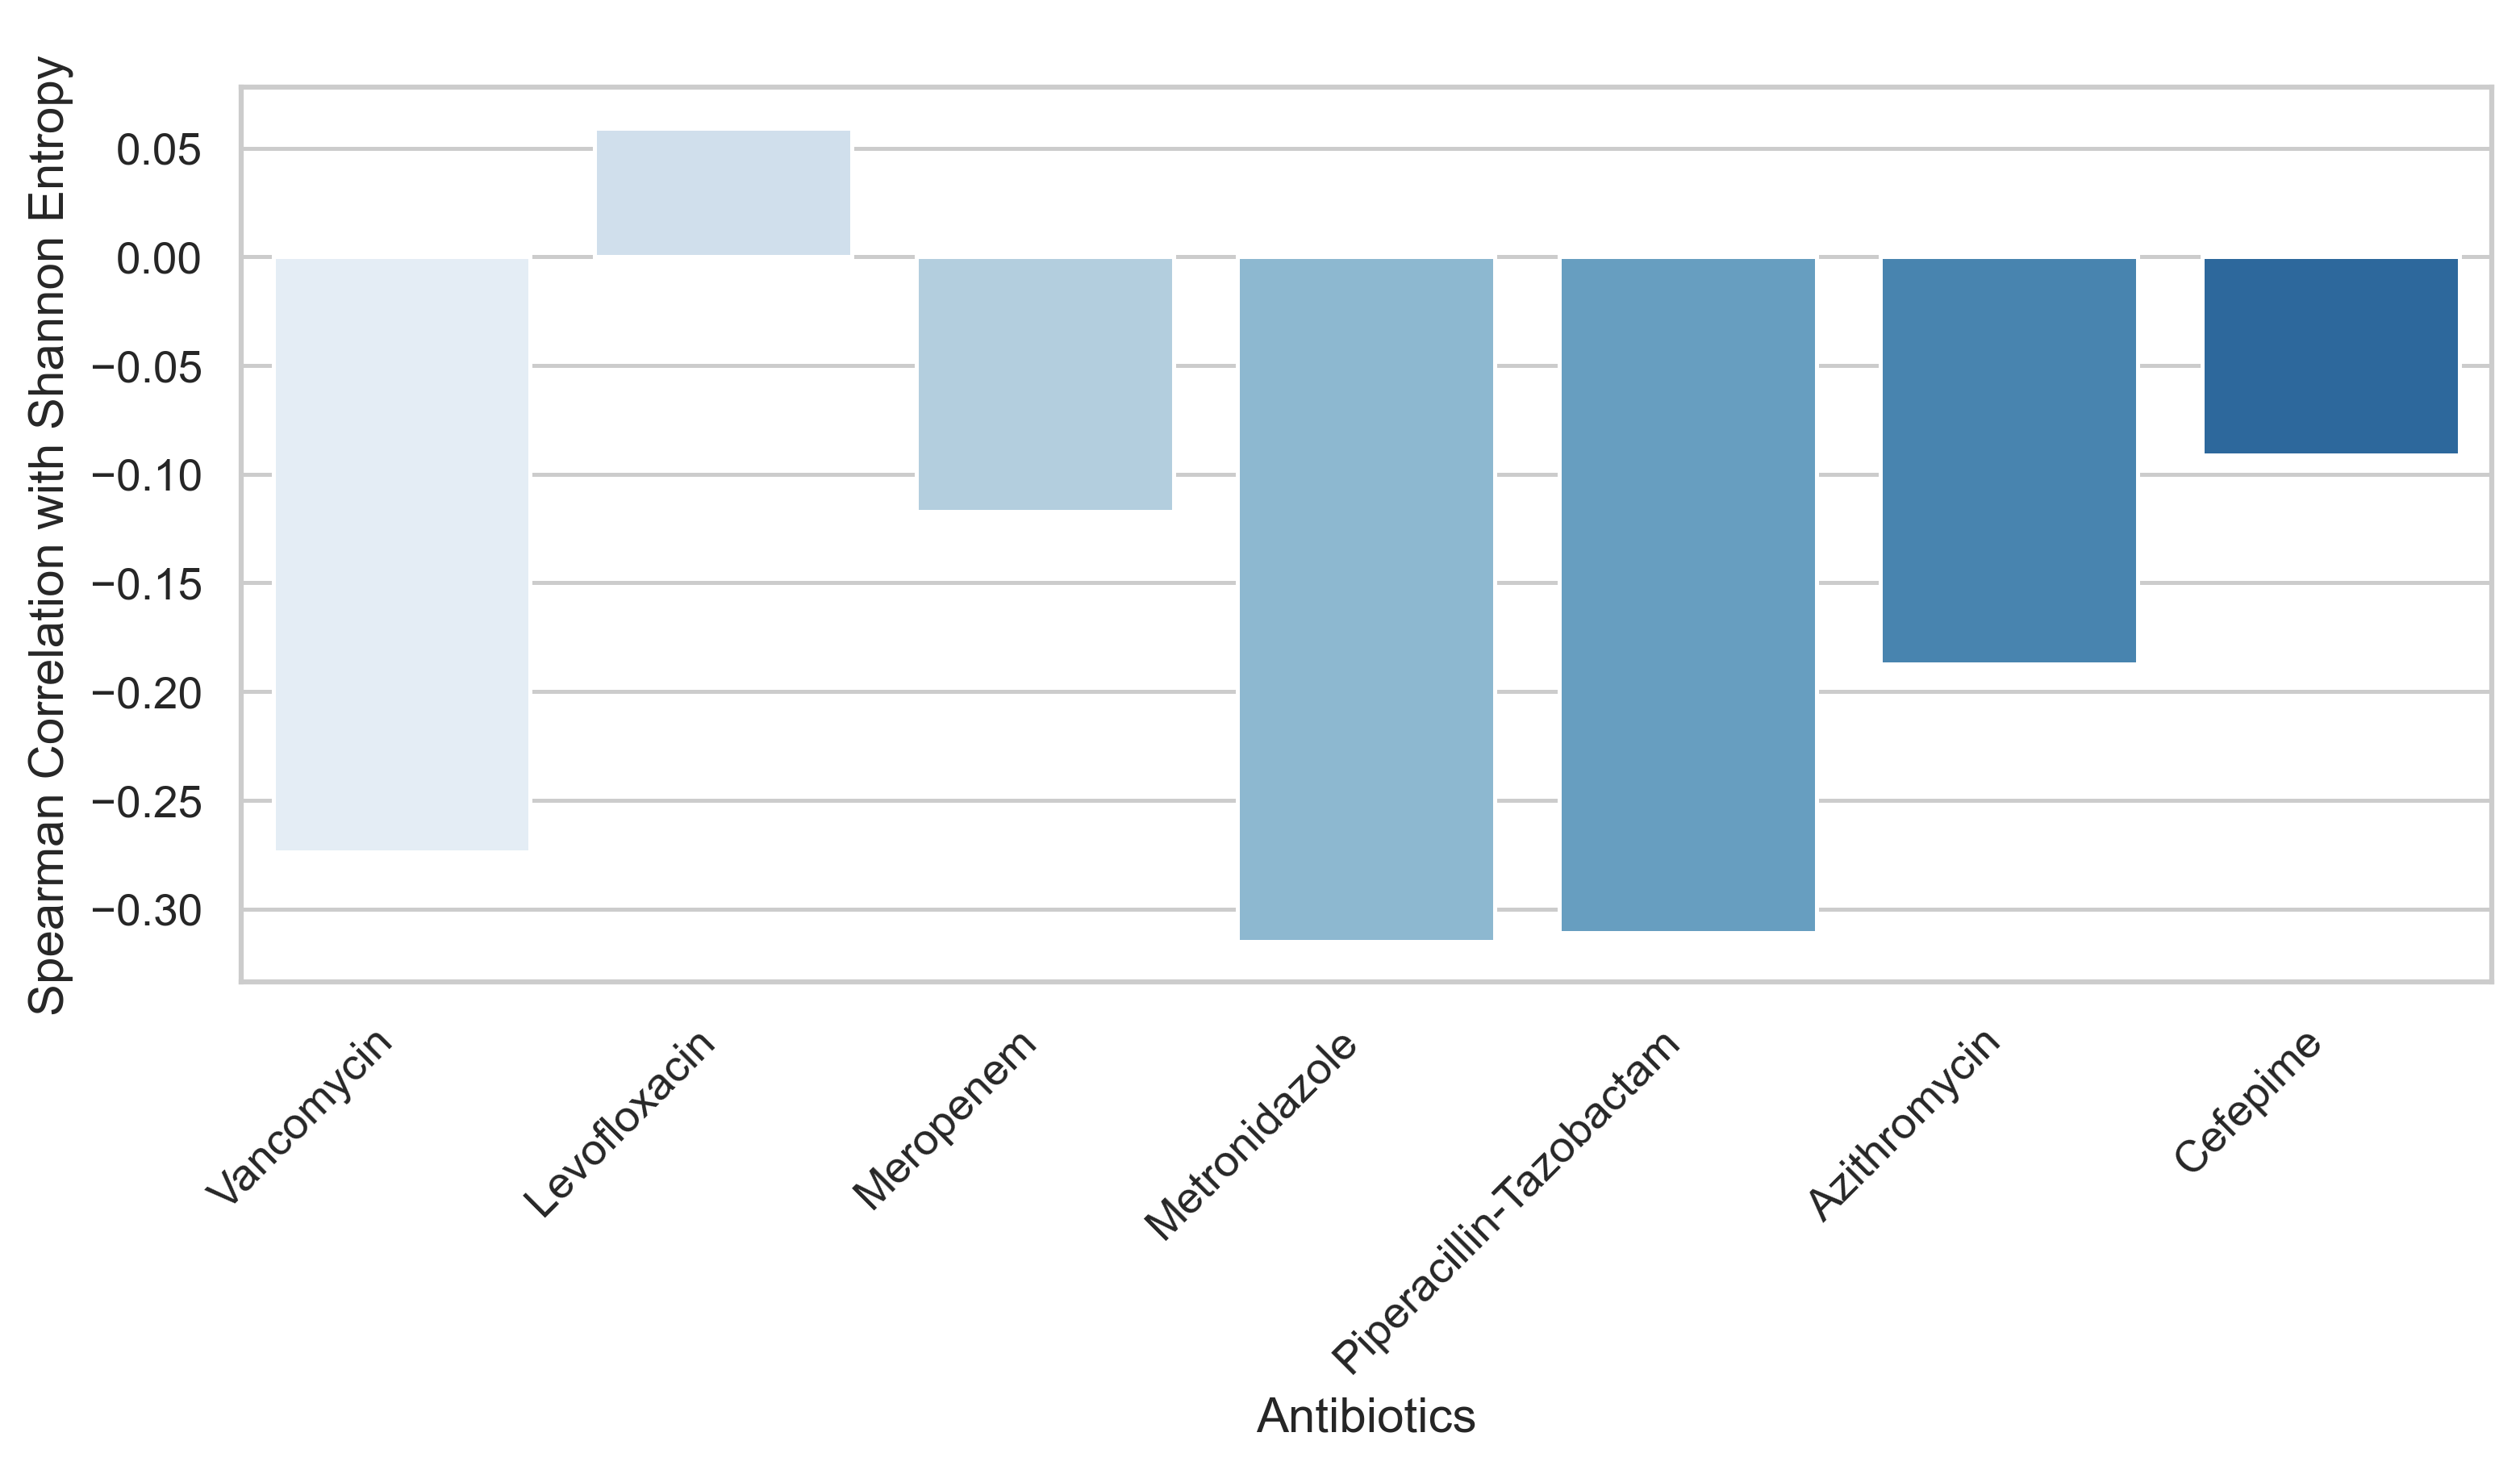

<Figure size 3600x1440 with 0 Axes>

In [56]:
# calculate the correlation
corr_df = shannon_abx_deday[['shannon_entropy','Vancomycin', 'Levofloxacin', 'Meropenem', 'Metronidazole', 'Piperacillin-Tazobactam', 'Azithromycin', 'Cefepime']]
corr = corr_df.corr(method='spearman')

first_row_corr = corr.iloc[0, 1:]
palette = sns.color_palette("Blues", 8)

# Create a barplot
plt.figure(figsize=(10, 4)) 
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 360 # Adjust the figsize as needed
sns.barplot(x=first_row_corr.index, y=first_row_corr.values, palette=palette)

# Add labels and title
plt.xlabel('Antibiotics')
plt.ylabel('Spearman Correlation with Shannon Entropy')
plt.title(' ')

# Rotate x-ticks for better readability
plt.xticks(rotation=45, ha='right')
plt.figure(figsize=(10, 4)) 
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 360

plt.show()


In [57]:
from scipy.stats import spearmanr

# Calculate spearman correlaiton
correlation_results = []

for antibiotic in corr_df.columns[0:]: 
    spearman_corr, spearman_p = spearmanr(corr_df[antibiotic], corr_df['shannon_entropy'])
    correlation_results.append({
        'Antibiotic': antibiotic,
        'Spearman_Correlation': spearman_corr,
        'Spearman_p_value': spearman_p
    })

correlation_df = pd.DataFrame(correlation_results)

correlation_df.head()



,Antibiotic,Spearman_Correlation,Spearman_p_value
0,shannon_entropy,1.000000,0.000000e+00
1,Vancomycin,-0.273651,2.769368e-08
2,Levofloxacin,0.059204,2.380272e-01
3,Meropenem,-0.117217,1.917383e-02
4,Metronidazole,-0.314900,1.236117e-10


In [60]:
antibiotic_decay_df = summary_df[['ID', 'Vancomycin', 'Levofloxacin', 'Metronidazole', 'Meropenem', 'Piperacillin-Tazobactam', 'Azithromycin', 'Cefepime']]
#antibiotic_decay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       494 non-null    object 
 1   Vancomycin               494 non-null    float64
 2   Levofloxacin             494 non-null    float64
 3   Metronidazole            494 non-null    float64
 4   Meropenem                494 non-null    float64
 5   Piperacillin-Tazobactam  494 non-null    float64
 6   Azithromycin             494 non-null    float64
 7   Cefepime                 494 non-null    float64
dtypes: float64(7), object(1)
memory usage: 31.0+ KB


In [61]:
#antibiotic_decay_df.to_csv('/Users/renata.m/QIIME2/qiime2-final_analysis-silva_abx/antibiotic_decay.csv')